# PUBLICAÇÕES DE ATOS JUDICIAIS

# 1. Entendimento do projeto

**Objetivo:** coletar, tratar, classificar e analisar publicações de atos judiciais.

**Dados:** Publicações de atos judiciais obtidas da plataforma do Diário da Justiça Eletrônico Nacional (DJEN), mantida pelo Conselho Nacional de Justiça (CNJ).

**Unidades judiciais:** Varas Cíveis do Termo Judiciário de São Luis/MA (1ª a 16ª).

**Período:** 01/01/2021 a 09/08/2021

# 2. Bibliotecas e funções

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings ('ignore')
import matplotlib.image as mpimg

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import _stop_words
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
import xgboost as xgb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Função de tratamento dos textos
def trata_texto(text):
    text = text.replace(regex=r'[!/,.-]', value='').apply(lambda x: x.lower())
    stop_words = stopwords.words('portuguese')
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    text = text.map(lambda x: word_tokenize(x))
    snowball = SnowballStemmer(language = 'portuguese')
    text = text.map(lambda x: [snowball.stem(y) for y in x])
    text = text.apply(lambda x: ' '.join(x))
    return text

# 3. Coleta dos dados

Os dados abaixo foram obtidos por meio do endereço da API do Conselho Nacional de Justiça (https://comunicaapi.pje.jus.br/), com uso das bibliotecas 'requests' e 'json' em python.

In [3]:
df = pd.read_csv('../data/dataset.csv')
df

,ids,data_disponibilizacao,orgao_julgador,numero_processo,nome_classe,texto
0,8001491,2021-08-09,1ª Vara Cível de São Luís,8179088820178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...
1,8001492,2021-08-09,1ª Vara Cível de São Luís,8463341320178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...
2,8001494,2021-08-09,1ª Vara Cível de São Luís,8126924920178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...
3,8001495,2021-08-09,1ª Vara Cível de São Luís,357571420148100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...
4,8001497,2021-08-09,1ª Vara Cível de São Luís,8149668320178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...
...,...,...,...,...,...,...
79618,39126,2021-01-11,16ª Vara Cível de São Luís,8126055920188100001,EXECUçãO DE TíTULO EXTRAJUDICIAL,Juízo de Direito da 16ª Vara Cível do Termo Ju...
79619,39157,2021-01-11,16ª Vara Cível de São Luís,8412624020208100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 16ª Vara Cível do Termo Ju...
79620,40423,2021-01-11,16ª Vara Cível de São Luís,8235001620178100001,EXECUçãO DE TíTULO EXTRAJUDICIAL,Juízo de Direito da 16ª Vara Cível do Termo Ju...
79621,40424,2021-01-11,16ª Vara Cível de São Luís,8002002020208100001,REINTEGRAçãO / MANUTENçãO DE POSSE,Juízo de Direito da 16ª Vara Cível do Termo Ju...


# 4. Tratamento dos textos

### 4.1. Preprocessamento

Chamamento da função criada para tratamento dos textos.
A função inclui as seguintes etapas:

    (1) remoção de caracteres especiais
    (2) conversão em letras minúsculas
    (3) remoção de stop words
    (4) tokenização
    (5) stemização

In [4]:
df['texto_processado'] = trata_texto(df['texto'])

### 4.2. Vetorização

In [5]:
tfidf = TfidfVectorizer(max_df=0.90, min_df=50, max_features=1000)
vectorized = tfidf.fit_transform(df['texto_processado'])
vectorized

<79623x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 8265038 stored elements in Compressed Sparse Row format>

# 5. Classificação dos textos

As publicações judicias não estão classificadas quanto ao tipo do ato judicial. Deste modo, realizou-se a rotulação dos textos dentre as seguintes categorias: 

    [ATO ORDINATÓRIO]
    [DESPACHO/DECISÃO]
    [SENTENÇA]
    [EDITAL]
    
Para tanto seguiu-se as seguintes etapas:

    1º) Clusterização dos textos para identificação das melhores amostras para rotulação manual
    2º) Classificação de todo coleção de textos a partir das amostras rotuladas

### 5.1. Clusterização - K-means

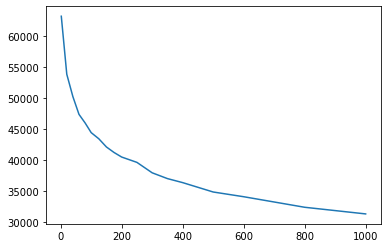

In [6]:
# Método do cotovelo para encontrar número ideeal de clusters
iters = [2, 20, 40, 60, 80, 100, 125, 150, 175, 200, 250, 300, 350, 400, 500, 600, 800, 1000]
sse = []
models = []
for k in iters:
    model = MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=42).fit(vectorized)
    sse.append(model.inertia_)
    
plt.plot(iters, sse)
plt.savefig(f'../img/elbow_method.png')
plt.show()

Utilizando o método do cotovelo não se identificou o número exato de clusters para o modelo, mas percebe-se pela representação gráfica que a partir de 100 clusters a variação da inércia (soma das distâncias quadradas das amostras ao centro do cluster) reduz significativamente.
Assim, promove-se a predição com o número de clusters definido em 100 e, após, classifica-se cada agrupamento em uma das categorias desejados.

In [7]:
# Predição do modelo com número de clusters k = 100
k = 100
model = MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=42).fit(vectorized)
df['cluster'] = model.predict(vectorized)

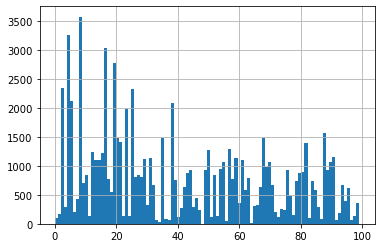

In [8]:
df['cluster'].hist(bins=100)

### 5.2. Identificando melhores amostras para rotulação manual - similaridade dos cossenos

In [9]:
# Melhores amostras de cada cluster por similaridade de cossenos
topn_indices = []
for i in range(0, 100):
    similarities = []
    centroid = model.cluster_centers_[i]
    for v in vectorized:
        similarities.append(cosine_similarity([centroid], v))
    indexes = np.array([s[0][0] for s in similarities])
    indexes = np.argsort(indexes)[::-1]
    topn_indices.append(indexes)

In [70]:
# Geração de nuvem de palavras sobre as 50 melhores amostras de cada cluster
topn = 50
stopwordcloud = ['var', 'cível', 'estad', 'maranhã', 'juíz', 'juiz', 'direit', 'term', 'luís', 'process', 'açã', 'secret', 'judicial', 'comarc', 'únic', 'digital', 'únic digital',
                 'unic', 'únic digital']
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, stopwords=stopwordcloud, random_state=42)
for i in range(0, 100):
    text_wordcloud = ' '.join(df['texto_processado'].iloc[topn_indices[i][0:topn]])
    nuvem = wordcloud.generate(text_wordcloud)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title(f'CLUSTER nº {i}')
    #plt.imshow(nuvem)
    #plt.savefig(f'../img/wordcloud_amostras_cluster_{i}.png')

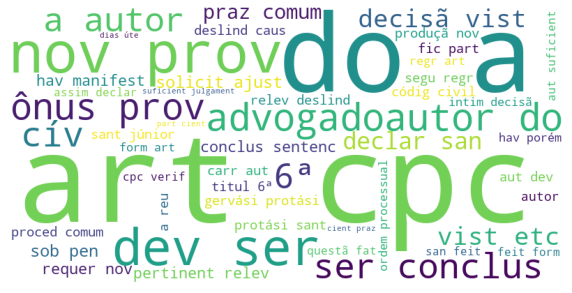

In [73]:
# Exemplo de uma das nuvens de palavras geradas
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(nuvem)

In [19]:
# Exportando indices das melhores amostras
np.savetxt('../data/topn_indices.csv', topn_indices, delimiter =",")

### 5.3. Rotulação manual

In [25]:
# Rotulação manual das melhores amostras de cada cluster
ato_ord = [1,2,5,6,8,10,15,17,19,21,23,25,28,34,44,45,48,50,54,55,66,78,86,95,96]
desp_dec = [0,11,12,14,16,18,20,22,24,26,29,30,31,32,35,36,43,46,49,51,52,53,56,58,59,60,61,62,64,65,68,69,70,71,73,74,75,77,79,82,83,84,85,88,94,97,99]
sentenca = [3,4,9,27,33,37,39,40,41,42,47,63,67,72,76,80,87,91,92,98]
edital = [7]

# Geração de dataset com amostras rotuladas
indices_amostras = []
for i in range(0, 100):
    for j in range(0, 50):
        indices_amostras.append(topn_indices[i][j])

df_amostras = df.loc[indices_amostras]
df_amostras['categoria'] = df_amostras['cluster'].apply(lambda x: 'ato_ord' if x in ato_ord else 'desp_dec' if x in desp_dec else 'sentenca' if x in sentenca else 'edital' if x in edital else 'indefinido')
df_amostras = df_amostras[['texto', 'categoria']]
df_amostras = df_amostras[df_amostras['categoria']!='indefinido']
df_amostras

,texto,categoria
76108,Juízo de Direito da 16ª Vara Cível do Termo Ju...,desp_dec
77235,Juízo de Direito da 16ª Vara Cível do Termo Ju...,desp_dec
76114,Juízo de Direito da 16ª Vara Cível do Termo Ju...,desp_dec
77233,Juízo de Direito da 16ª Vara Cível do Termo Ju...,desp_dec
77577,Juízo de Direito da 16ª Vara Cível do Termo Ju...,desp_dec
...,...,...
33412,Juízo de Direito da 6ª Vara Cível do Termo de ...,desp_dec
28738,Juízo de Direito da 6ª Vara Cível do Termo de ...,desp_dec
28737,Juízo de Direito da 6ª Vara Cível do Termo de ...,desp_dec
29279,Juízo de Direito da 6ª Vara Cível do Termo de ...,desp_dec


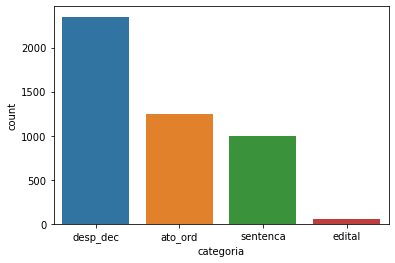

In [26]:
# Frequência das categorias
sns.countplot(df_amostras['categoria'])

In [27]:
# Exportando dataset
df_amostras.to_csv('../data/dataset_amostras_rotulado.csv')

### 5.4. Treinamento e avaliação dos algoritmos de classificação

In [55]:
# Dados de treino
X_train = df_amostras['texto']
y_train = df_amostras['categoria']

# Dados de teste - classificados manualmente pelo Stakeholder
df_teste = pd.read_csv('../data/dataset_validacao.csv')
X_test = df_teste['texto']
y_test = df_teste['categoria']

# Preprocessamento
X_train = trata_texto(X_train)
X_train = tfidf.transform(X_train)

X_test = trata_texto(X_test)
X_test = tfidf.transform(X_test)

In [56]:
X_train

<4650x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 533287 stored elements in Compressed Sparse Row format>

In [57]:
X_test

<59x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 5634 stored elements in Compressed Sparse Row format>

In [58]:
df_teste['categoria'].value_counts()

desp_dec    30
ato_ord     15
sentenca     9
edital       5
Name: categoria, dtype: int64

#### Regressão logística

              precision    recall  f1-score   support

     ato_ord       1.00      0.93      0.97        15
    desp_dec       0.86      1.00      0.92        30
      edital       1.00      0.20      0.33         5
    sentenca       1.00      1.00      1.00         9

    accuracy                           0.92        59
   macro avg       0.96      0.78      0.81        59
weighted avg       0.93      0.92      0.90        59



Text(0.5, 1.0, 'Logistic_Regression')

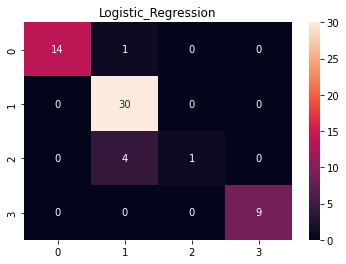

In [59]:
# Treino e Predição
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='.0f').set_title('Logistic_Regression')

#### Árvore de decisão

              precision    recall  f1-score   support

     ato_ord       1.00      1.00      1.00        15
    desp_dec       0.88      0.93      0.90        30
      edital       1.00      0.60      0.75         5
    sentenca       0.78      0.78      0.78         9

    accuracy                           0.90        59
   macro avg       0.91      0.83      0.86        59
weighted avg       0.90      0.90      0.90        59



Text(0.5, 1.0, 'Decision_Tree')

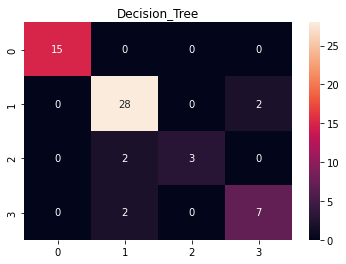

In [60]:
# Treino e Predição
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred = dtree.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='.0f').set_title('Decision_Tree')

#### Floresta aleatória

              precision    recall  f1-score   support

     ato_ord       1.00      1.00      1.00        15
    desp_dec       0.88      1.00      0.94        30
      edital       1.00      0.20      0.33         5
    sentenca       1.00      1.00      1.00         9

    accuracy                           0.93        59
   macro avg       0.97      0.80      0.82        59
weighted avg       0.94      0.93      0.91        59



Text(0.5, 1.0, 'Random_Forest')

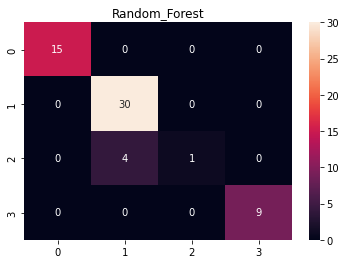

In [61]:
# Treino e Predição
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='.0f').set_title('Random_Forest')

#### Impulso do gradiante extremo

[09:51:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

     ato_ord       1.00      1.00      1.00        15
    desp_dec       0.88      1.00      0.94        30
      edital       1.00      0.20      0.33         5
    sentenca       1.00      1.00      1.00         9

    accuracy                           0.93        59
   macro avg       0.97      0.80      0.82        59
weighted avg       0.94      0.93      0.91        59



Text(0.5, 1.0, 'XGBoost')

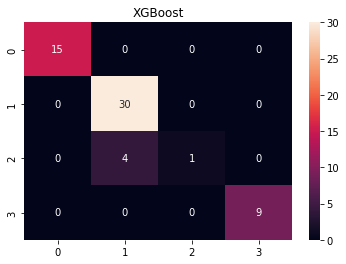

In [62]:
# Treino e Predição
xgbmodel = xgb.XGBClassifier(random_state=0)
xgbmodel.fit(X_train,y_train)
y_pred=xgbmodel.predict(X_test)

# Avaliação
print(classification_report(y_test,y_pred))
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='.0f').set_title('XGBoost')

**Conclusão sobre os algoritmos classificadores:*** Considerando a acurácia e precisão dos classificadores treinados, observa-se que o algoritmo FLORESTA ALEATÓRIA (Random Forest) apresentou melhor performance.

### 5.5.  Classificação final do conjunto de dados

In [63]:
# Conjunto de dados para classificação final
df['categoria'] = rf.predict(vectorized)
df

,ids,data_disponibilizacao,orgao_julgador,numero_processo,nome_classe,texto,texto_processado,cluster,categoria
0,8001491,2021-08-09,1ª Vara Cível de São Luís,8179088820178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...,juíz direit 1ª var cível term luís secret judi...,4,sentenca
1,8001492,2021-08-09,1ª Vara Cível de São Luís,8463341320178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...,juíz direit 1ª var cível term luís secret judi...,38,desp_dec
2,8001494,2021-08-09,1ª Vara Cível de São Luís,8126924920178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...,juíz direit 1ª var cível term luís secret judi...,4,sentenca
3,8001495,2021-08-09,1ª Vara Cível de São Luís,357571420148100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...,juíz direit 1ª var cível term luís secret judi...,12,desp_dec
4,8001497,2021-08-09,1ª Vara Cível de São Luís,8149668320178100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 1ª Vara Cível do Termo de ...,juíz direit 1ª var cível term luís secret judi...,4,sentenca
...,...,...,...,...,...,...,...,...,...
79618,39126,2021-01-11,16ª Vara Cível de São Luís,8126055920188100001,EXECUçãO DE TíTULO EXTRAJUDICIAL,Juízo de Direito da 16ª Vara Cível do Termo Ju...,juíz direit 16ª var cível term judiciári luis ...,68,desp_dec
79619,39157,2021-01-11,16ª Vara Cível de São Luís,8412624020208100001,PROCEDIMENTO COMUM CíVEL,Juízo de Direito da 16ª Vara Cível do Termo Ju...,juíz direit 16ª var cível term judiciári luis ...,4,desp_dec
79620,40423,2021-01-11,16ª Vara Cível de São Luís,8235001620178100001,EXECUçãO DE TíTULO EXTRAJUDICIAL,Juízo de Direito da 16ª Vara Cível do Termo Ju...,juíz direit 16ª var cível term judiciári luis ...,68,desp_dec
79621,40424,2021-01-11,16ª Vara Cível de São Luís,8002002020208100001,REINTEGRAçãO / MANUTENçãO DE POSSE,Juízo de Direito da 16ª Vara Cível do Termo Ju...,juíz direit 16ª var cível term judiciári luis ...,43,desp_dec


In [67]:
# Exportando dataset final para análise no Power Bi
df.to_csv('../data/dataset_final.csv')

# 6. Análise dos dados finais no Power BI

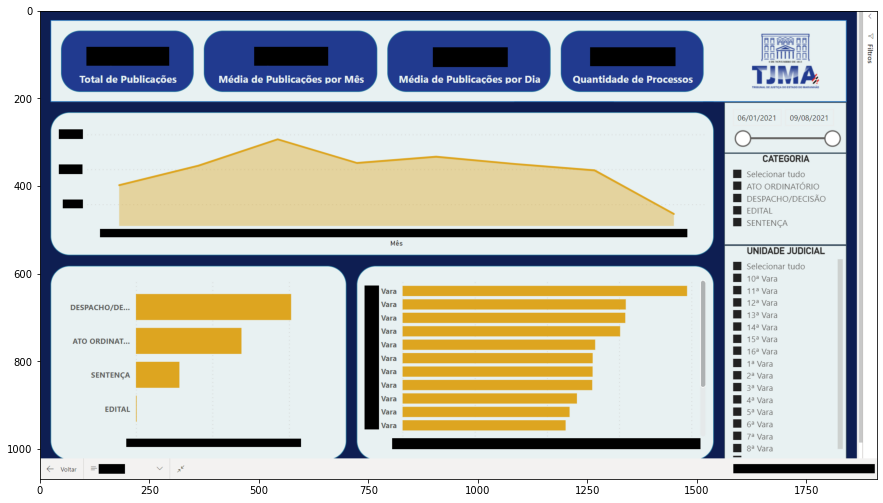

In [69]:
img = mpimg.imread('../img/imagem_dashboard.png')
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()